In [2]:
from tensorflow import keras
from keras.applications import VGG19
from keras.applications import imagenet_utils
from keras.utils import img_to_array
from keras.utils import load_img
import numpy as np
import cv2

In [3]:
inputShape = (224, 224) #fixed input size for vgg19
#preprocessing inputs before they are fed into model.to match the input format of the original models.
preprocess = imagenet_utils.preprocess_input
     

In [4]:
Network = VGG19
model = Network(weights="imagenet")
path="healthy.jpg"
image = load_img(path, target_size=inputShape)
image = img_to_array(image)


In [5]:
print(image.shape)

(224, 224, 3)


In [6]:
#add an extra dimension to the numpy array image so that it can be passed as input to the model.
image = np.expand_dims(image, axis=0)  
print(image.shape)
# pre-process the image using the appropriate function based on the
# model that has been loaded (i.e., mean subtraction, scaling, etc.)
image = preprocess(image)

(1, 224, 224, 3)


In [7]:
preds = model.predict(image)
P = imagenet_utils.decode_predictions(preds)

1/1 [==============================] - 1s 1s/step


In [8]:
# loop over the predictions and display the rank-5 predictions +
# probabilities to our terminal
for (i, (imagenetID, label, prob)) in enumerate(P[0]):
	print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))


1. packet: 17.01%
2. maze: 12.60%
3. wallet: 9.67%
4. mousetrap: 5.95%
5. pillow: 5.24%


In [9]:
# load the image via OpenCV, draw the top prediction on the image,
# and display the image to our screen
orig = cv2.imread(path)
(imagenetID, label, prob) = P[0][0]
orig=cv2.putText(orig, "Label: {}, {:.2f}%".format(label, prob * 100),(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)


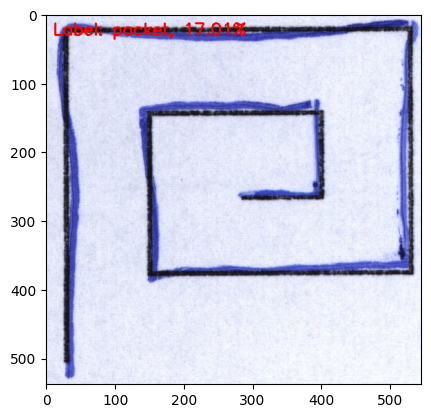

In [10]:
from matplotlib import pyplot as plt

plt.imshow(orig[:,:,::-1])
plt.show()

In [11]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
import os
from PIL import Image
X = []
Y= []
inputShape=(224,224)
for filename in os.listdir('PatientMeanderwithAug'):
    try:
        image_path = os.path.join('PatientMeanderwithAug', filename)
        with Image.open(image_path) as image:
            image = image.resize(inputShape)
            image = np.asarray(image)
            X.append(image)
            Y.append(1)   #1:patient
    except Exception as e:
        print(f"Error loading image {filename}: {e}")
        
for filename in os.listdir('HealthyMeanderwithAug'):
    try:
        image_path = os.path.join('HealthyMeanderwithAug', filename)
        with Image.open(image_path) as image:
            image = image.resize(inputShape)
            image = np.asarray(image)
            X.append(image)
            Y.append(0) #0:healthy
    except Exception as e:
        print(f"Error loading image {filename}: {e}")

In [13]:
first_frame = X[0]
print(first_frame.shape)

(224, 224, 3)


In [14]:
print(len(X))
len((Y))
     

1409


1409

In [15]:
#shuffling the images and their corresponding labels 
import numpy as np
X = np.array(X)
Y = np.array(Y)

indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices]
Y = Y[indices]
X

array([[[[240, 243, 248],
         [240, 243, 248],
         [245, 248, 253],
         ...,
         [243, 246, 255],
         [245, 248, 255],
         [245, 248, 253]],

        [[245, 248, 253],
         [244, 247, 252],
         [248, 251, 255],
         ...,
         [239, 242, 251],
         [241, 244, 253],
         [242, 245, 252]],

        [[243, 246, 253],
         [241, 244, 250],
         [243, 246, 252],
         ...,
         [240, 243, 252],
         [243, 246, 254],
         [240, 243, 251]],

        ...,

        [[230, 233, 250],
         [232, 235, 252],
         [229, 232, 249],
         ...,
         [240, 242, 253],
         [240, 242, 254],
         [244, 247, 254]],

        [[230, 233, 250],
         [230, 233, 250],
         [229, 232, 249],
         ...,
         [238, 241, 251],
         [242, 245, 254],
         [245, 248, 254]],

        [[232, 235, 252],
         [229, 232, 249],
         [227, 230, 247],
         ...,
         [241, 244, 252],
        

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [17]:
X_train
Y_train


array([0, 1, 1, ..., 0, 1, 1])

In [18]:
print(len( X_train))
print (len(Y_train))
print( len(X_test))
print( len(Y_test))

1127
1127
282
282


In [19]:
from collections import Counter
Counter(Y_train)

Counter({1: 887, 0: 240})

In [20]:
import keras
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
     

In [21]:
model = Network(weights="imagenet",include_top=False)
x=model.output
x=GlobalAveragePooling2D()(x)
#we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) 
x=Dense(512,activation='relu')(x) 
preds=Dense(1,activation='sigmoid')(x) #final layer 

In [22]:
model=Model(inputs=model.input,outputs=preds)

In [23]:
len(model.layers)

26

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [25]:
#sets the first 23 layers of the model to be non-trainable, while setting the remaining layers to be trainable.
for layer in model.layers[:23]:
    layer.trainable=False
for layer in model.layers[23:]:
    layer.trainable=True

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [27]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [28]:
X_train=np.array(X_train)
X_train

array([[[[229, 232, 247],
         [233, 236, 251],
         [231, 234, 249],
         ...,
         [244, 247, 255],
         [244, 247, 255],
         [242, 245, 254]],

        [[233, 236, 251],
         [236, 239, 253],
         [230, 233, 248],
         ...,
         [242, 245, 254],
         [240, 243, 252],
         [239, 242, 251]],

        [[229, 232, 247],
         [235, 238, 253],
         [233, 236, 251],
         ...,
         [241, 244, 253],
         [238, 241, 250],
         [237, 240, 249]],

        ...,

        [[227, 232, 252],
         [223, 227, 247],
         [231, 234, 251],
         ...,
         [233, 237, 248],
         [234, 237, 250],
         [232, 235, 250]],

        [[228, 233, 251],
         [214, 219, 238],
         [232, 235, 251],
         ...,
         [232, 236, 247],
         [233, 236, 249],
         [235, 238, 253]],

        [[227, 233, 250],
         [217, 221, 238],
         [230, 233, 248],
         ...,
         [239, 243, 254],
        

In [29]:
history=model.fit(X_train,np.array(Y_train),epochs=10,validation_data=(X_test, np.array(Y_test)))

Epoch 1/10
36/36 [==============================] - 711s 20s/step - loss: 1.3935 - accuracy: 0.7587 - val_loss: 0.2383 - val_accuracy: 0.8936
Epoch 2/10
36/36 [==============================] - 614s 17s/step - loss: 0.2882 - accuracy: 0.8846 - val_loss: 0.1909 - val_accuracy: 0.9184
Epoch 3/10
36/36 [==============================] - 631s 18s/step - loss: 0.1786 - accuracy: 0.9414 - val_loss: 0.1331 - val_accuracy: 0.9468
Epoch 4/10
36/36 [==============================] - 707s 20s/step - loss: 0.1255 - accuracy: 0.9601 - val_loss: 0.1245 - val_accuracy: 0.9433
Epoch 5/10
36/36 [==============================] - 722s 20s/step - loss: 0.1075 - accuracy: 0.9610 - val_loss: 0.0918 - val_accuracy: 0.9681
Epoch 6/10
36/36 [==============================] - 628s 18s/step - loss: 0.0622 - accuracy: 0.9823 - val_loss: 0.0656 - val_accuracy: 0.9752
Epoch 7/10
36/36 [==============================] - 611s 17s/step - loss: 0.0362 - accuracy: 0.9911 - val_loss: 0.0592 - val_accuracy: 0.9787
Epoch 

In [30]:
preds=model.predict(X_train)

36/36 [==============================] - 532s 15s/step


In [31]:
preds

array([[3.3458753e-04],
       [9.9536103e-01],
       [9.9542052e-01],
       ...,
       [3.7936463e-03],
       [9.9999255e-01],
       [9.9995208e-01]], dtype=float32)

In [32]:
preds[preds>0.5]=1
preds[preds<0.5]=0
     

from sklearn.metrics import confusion_matrix
confusion_matrix(Y_train, preds)

array([[240,   0],
       [  0, 887]], dtype=int64)

In [30]:

def saveModel(model):
    model_json = model.to_json()
    with open("m.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("m.h5")
    print('Model Saved')
saveModel(model)

Model Saved
